In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import Normalize
from matplotlib import cm as cmapper
from matplotlib.colors import LogNorm
from matplotlib import cm

import cartopy.crs as ccrs

from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.table import QTable

from spectral_cube import SpectralCube

%matplotlib notebook

In [2]:
#Load High ion absorption line measurements
summed_columns = QTable.read("Data/SUMMED_ION_COLUMNS.fits")
    
#Load HI Milky Way Background Data
with open("/Users/dk/Downloads/MW_MOMENT_HI.pkl", "rb") as f:
    mw_data = pickle.load(f)

#Load HI Magellanic Data
with open("/Users/dk/Downloads/PRELIM_STREAM_MOMENT_HI_v2.pkl", "rb") as f:
    stream_data = pickle.load(f)

In [3]:
# Set some Initial parameters to plot
source_gal = SkyCoord(l = summed_columns["GAL_LON"], b = summed_columns["GAL_LAT"], frame = "galactic")
lmc_gal = SkyCoord(l = 280.4652, b = -32.8884, unit = u.deg, frame = "galactic")

ZZ = summed_columns["LOG_N_CIV"]
VZ = summed_columns["MEAN_CIV_V"]
ZZ_UL = summed_columns["LOG_N_ERR_CIV"] < 0

cmap2 = sns.color_palette("YlOrBr_r", as_cmap=True)

cmap = sns.color_palette("mako", as_cmap=True)

In [4]:
# Get impact parameter contours
levels = [5, 15, 30, 45]
gridx = -Angle(np.arange(200,340,1.)*u.deg).wrap_at("180d").value
gridy = np.arange(-85,15,1.)
xx, yy = np.meshgrid(gridx, gridy, indexing = "ij")
coords = SkyCoord(l = xx*u.deg, b = yy*u.deg, frame = "galactic")
distance = 50*u.kpc
LMC_gal_flipped = SkyCoord(l = -lmc_gal.l.wrap_at("180d"), b = lmc_gal.b, frame = "galactic")
impact_par_grid = np.tan(LMC_gal_flipped.separation(coords)) * distance

In [5]:
# Set normalization ranges
col_den_factor = 1.823*10**18 * u.cm**-2 / (u.K * u.km/u.s)
clip_value = 10**18* u.cm**-2
clip_value2 = 10**20* u.cm**-2

norm = LogNorm(vmin = clip_value.to(u.cm**-2).value, vmax = 5e21)
norm_lin = Normalize(vmin = 18, vmax = 21.7)
norm2 = LogNorm(vmin = clip_value2.to(u.cm**-2).value, vmax = 1e25)

<IPython.core.display.Javascript object>


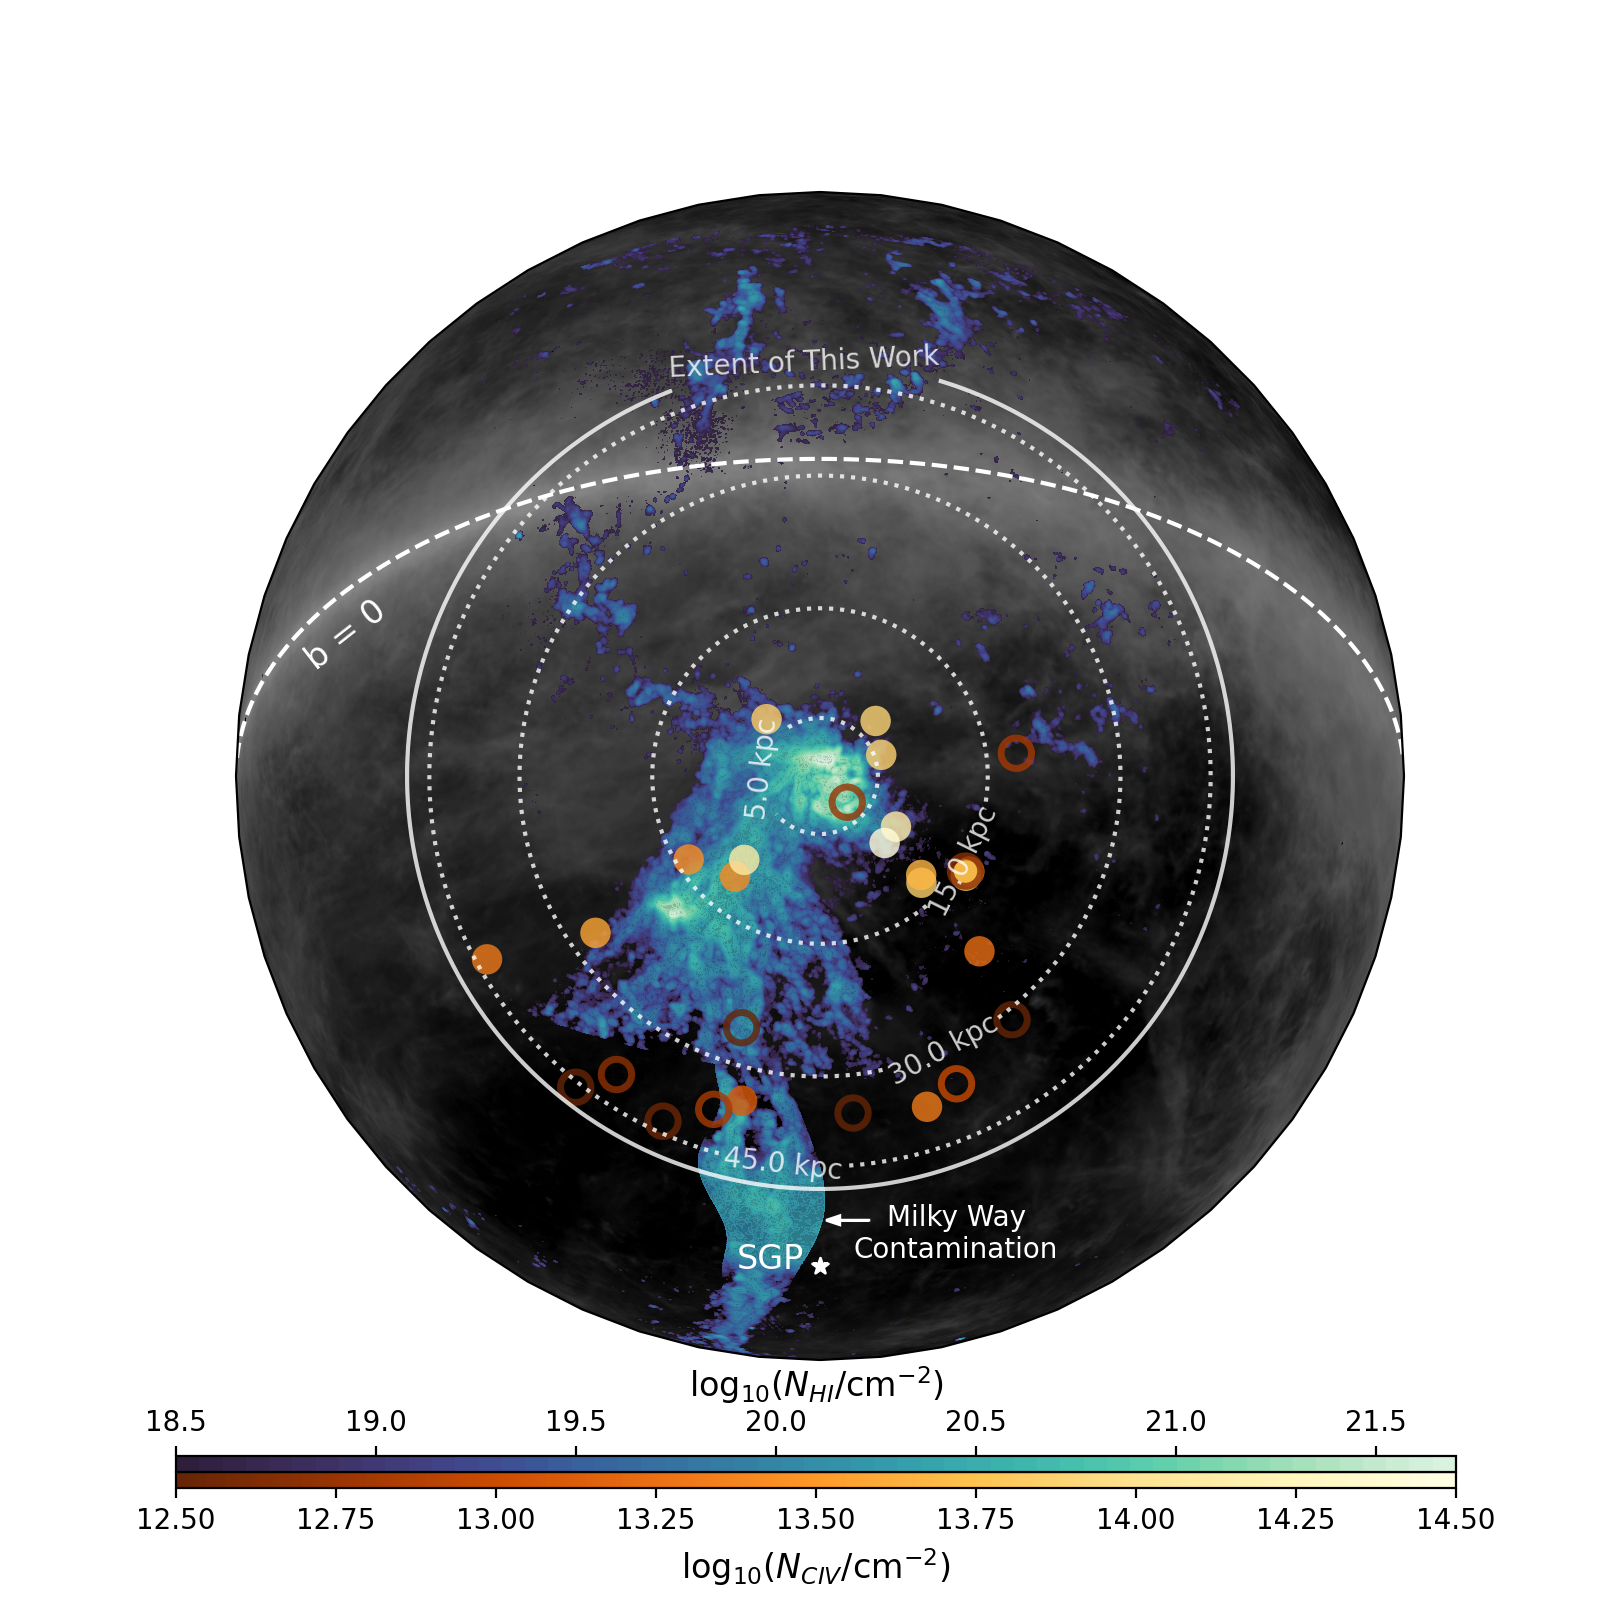

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

In [6]:
fig = plt.figure(figsize = (8,8))

# Orthographic Projection
ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=LMC_gal_flipped.l.wrap_at("180d").value, 
                                                  central_latitude=LMC_gal_flipped.b.value,))

#Background MW Image
im = ax.pcolormesh(mw_data["l"], mw_data["b"], mw_data["moment_18"], 
              shading='nearest', 
              transform = ccrs.PlateCarree(), norm = norm2, cmap = "Greys_r")

# Foreground Stream Image
im = ax.contourf(stream_data["l"], stream_data["b"], np.log10(stream_data["moment_18"]), 
              transform = ccrs.PlateCarree(), cmap = cmap, norm = norm_lin, alpha = 0.8, 
                 levels = np.log10(np.logspace(18.5,21.7,56)))


# CIV Points and Upper limits
# nan_inf_mask = np.isnan(ZZ) | np.isinf(ZZ)
norm_CIV = Normalize(vmin = 12.5, vmax = 14.5)

sc = ax.scatter(-source_gal.l.value[~ZZ_UL], source_gal.b.value[~ZZ_UL], 
           transform = ccrs.PlateCarree(), 
           c = ZZ[~ZZ_UL], 
           cmap = cmap2, 
           alpha = 0.8, 
           norm = norm_CIV, 
                s = 120, 
                edgecolor = "w", linestyle = "-", linewidth = 0.)



cmapper = cm.ScalarMappable(cmap = cmap2, norm = norm_CIV)
                

#Outlines Only for Upper Limits
_ = ax.scatter(-source_gal.l.value[ZZ_UL], 
                source_gal.b.value[ZZ_UL], 
           transform = ccrs.PlateCarree(), 
           facecolor = 'none',
           cmap = cmap2, 
           alpha = 0.8,
           norm = norm_CIV,  
                s = 120, 
                edgecolor = cmapper.to_rgba(ZZ[ZZ_UL]), 
                linestyle = "-", 
                linewidth = 2.5)





# Coordinate Labels

SP = ax.text(0,-85, "SGP",
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12)

_ = ax.scatter(0, -90, color = "w", marker = "*", 
               transform = ccrs.PlateCarree())

ll = np.arange(-180,179.9,.1)
bb = np.zeros_like(ll)

_ = ax.plot(ll, bb, ls = "--", color = "w", transform = ccrs.PlateCarree())

EQ = ax.text(25, -5, "b = 0", 
             transform = ccrs.PlateCarree(), 
             color = "w", 
             va = "center", 
             ha = "center", 
             fontsize = 12, rotation = 38)


# Impact Parameter Contours
ct = ax.contour(xx, yy, impact_par_grid, 
                levels = levels, 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = ":")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "{} kpc".format(lab)
ax.clabel(ct, ct.levels, fmt = fmt)

ct = ax.contour(xx, yy, impact_par_grid, 
                levels = [50], 
                transform = ccrs.PlateCarree(),
                colors = "w", 
                alpha = 0.8, 
                linestyles = "-")

fmt = {}
for lab in ct.levels:
    fmt[lab] = "Extent of This Work"
manual_locations = [(-1.725e5,4.506e6),]
ax.clabel(ct, ct.levels, fmt = fmt, manual=manual_locations)


_ = ax.set_global()



# Add Colorbar
plt.subplots_adjust(bottom = .15)

cax = fig.add_axes([.11,.07,.8,.01])
cax2 = fig.add_axes([.11,.08,.8,.01])

cbar = plt.colorbar(sc, cax = cax, orientation = "horizontal")
cbar.solids.set(alpha=1)


cbar2 = plt.colorbar(im, cax = cax2, orientation = "horizontal", ticks = [18.5,19,19.5,20,20.5,21,21.5])
cbar2.solids.set(alpha=1)
cax2.xaxis.tick_top()
cax2.xaxis.set_label_position("top")

cax2.set_xlabel(r"$\log_{10}(N_{HI}/\mathrm{cm}^{-2})$", fontsize = 12)
cax.set_xlabel(r"$\log_{10}(N_{CIV}/\mathrm{cm}^{-2})$", fontsize = 12)

# Extra Label
ax.arrow(5.339e5,-4.852e6,-(5.339e5-5.759e4)/1.5,0, 
         head_width = 1e5, color = "w")
ax.text(5.339e5+(5.339e5-5.759e4)*2, -5e6, "Milky Way\nContamination", 
         va = "center", ha = "center", fontsize = 10, color = "w")

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/Figure1_LeftPanel.png", 
            dpi = 300, transparent = True)